## 1. Instalación y Setup

In [ ]:
# Instalamos librerías necesarias:
# - torchvision: incluye modelos preentrenados (como ResNet), transformaciones para imágenes, etc.
# - gdown: permite descargar archivos desde Google Drive (muy útil en Colab)
!pip install torchvision gdown

# ------------------------- #
# BLOQUE DE IMPORTACIONES
# ------------------------- #

import os  # Para trabajar con el sistema de archivos (crear rutas, leer carpetas, etc.)
import zipfile  # Para descomprimir archivos ZIP (por ejemplo, datasets)
import torch  # Librería principal de deep learning: define tensores, modelos, entrenamiento, etc.
import numpy as np  # Librería de computación numérica (muy usada con tensores)
from PIL import Image  # Para abrir y procesar imágenes (Pillow)
import matplotlib.pyplot as plt  # Para visualizar imágenes y gráficos (curvas de pérdida, accuracy, etc.)
from collections import Counter  # Para contar ocurrencias de clases, útil en datasets desbalanceados
from torch.utils.data import DataLoader, Dataset  # Utilidades para crear datasets personalizados y cargar datos en batches
from torchvision import transforms, models  # transforms: para preprocesar imágenes; models: modelos preentrenados como ResNet
from sklearn.model_selection import train_test_split  # Para dividir el dataset en entrenamiento/validación/test
from torch import nn, optim  # nn: para definir redes (capas, funciones de activación, pérdidas); optim: para definir optimizadores
import pandas as pd  # Para leer y trabajar con archivos CSV (por ejemplo, etiquetas del dataset)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("⚠️ GPU no disponible, se usará CPU")

✅ GPU disponible: Tesla T4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo usado para entrenar:", device)

Dispositivo usado para entrenar: cuda


## 2. Descargar y preparar dataset UTKFace

In [ ]:
import gdown

# Descargar el archivo zip
file_id = "12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx"
output_zip = "UTKFace.zip"

if not os.path.exists(output_zip):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Descomprimir
if not os.path.exists("UTKFace"):
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall("UTKFace")


Downloading...
From (original): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx
From (redirected): https://drive.google.com/uc?id=12azyA3m0TGxmTjErPjdIYEYWAyEFjwYx&confirm=t&uuid=3d19a80c-1dda-4f32-928f-3fb7fbbe6e76
To: /content/UTKFace.zip
100%|██████████| 1.40G/1.40G [00:20<00:00, 67.4MB/s]


## 3. Definir funciones y filtrar imágenes de hombres con validación de nombre

In [ ]:
# Ruta donde se encuentra el dataset UTKFace (debe estar previamente descargado y descomprimido)
dataset_path = "UTKFace"

# Lista para almacenar las imágenes de hombres junto con su categoría etaria
male_images = []

# Función para mapear la edad numérica a una categoría (clasificación multiclase)
# Estas categorías representan rangos etarios definidos previamente (por ejemplo, niño, joven, adulto, etc.)
def get_age_category(age):
    if age <= 3:
        return 0  # Bebé
    elif age <= 12:
        return 1  # Niño
    elif age <= 23:
        return 2  # Adolescente o joven
    elif age <= 30:
        return 3  # Joven adulto
    elif age <= 44:
        return 4  # Adulto
    elif age <= 60:
        return 5  # Adulto mayor
    else:
        return 6  # Anciano

# Recorremos todos los archivos de la carpeta del dataset
for fname in os.listdir(dataset_path):
    # Filtramos solo imágenes (archivos con extensión .jpg o .png)
    if fname.endswith((".jpg", ".png")):
        partes = fname.split("_")  # El nombre de archivo tiene el formato: edad_genero_raza_fecha.jpg
        # Verificamos que tenga al menos 4 partes y que las dos primeras (edad y género) sean números
        if len(partes) >= 4 and partes[0].isdigit() and partes[1].isdigit():
            age = int(partes[0])       # Edad de la persona
            gender = int(partes[1])    # Género: 0 = hombre, 1 = mujer
            if gender == 0:
                # Agregamos solo las imágenes de hombres a la lista, con su categoría etaria
                male_images.append((fname, get_age_category(age)))


## 4. Análisis de distribución por clase

📊 Cantidad de imágenes por rango etario:
        Rango etario  Cantidad
          Bebé (0-3)      1067
         Niño (4-12)       651
 Adolescente (13-23)      1031
Joven Adulto (24-30)      2927
      Adulto (31-44)      2912
Adulto Mayor (45-60)      2579
       Anciano (>60)      1414


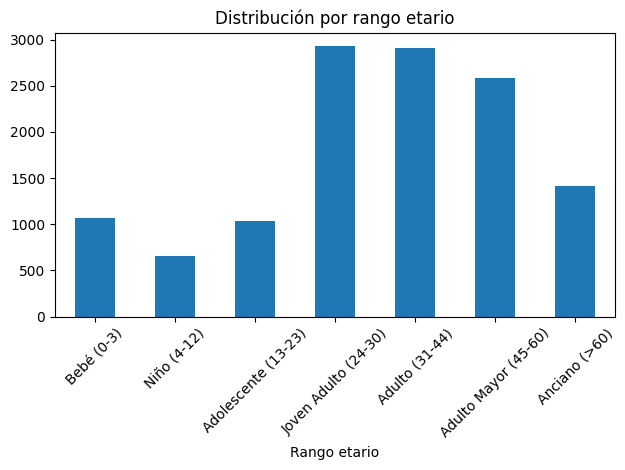

In [ ]:
# Lista con nombres descriptivos para cada categoría de edad (de acuerdo a la función get_age_category)
label_names = [
    "Bebé (0-3)", "Niño (4-12)",
    "Adolescente (13-23)", "Joven Adulto (24-30)", "Adulto (31-44)",
    "Adulto Mayor (45-60)", "Anciano (>60)"
]

# Extraemos solo las etiquetas (categorías de edad) de la lista male_images
labels = [label for _, label in male_images]

# Contamos cuántas imágenes hay por cada categoría usando Counter (de la librería collections)
class_counts = Counter(labels)

# Creamos un DataFrame de pandas para tener una tabla ordenada con la distribución
df = pd.DataFrame({
    'Rango etario': label_names,  # Nombres legibles para cada rango
    'Cantidad': [class_counts.get(i, 0) for i in range(7)]  # Cantidad de imágenes por categoría (0 si no existe)
})

# Imprimimos la tabla con la cantidad de imágenes por cada rango etario
print("📊 Cantidad de imágenes por rango etario:")
print(df.to_string(index=False))  # Mostramos sin índice para mayor limpieza visual

# Graficamos un diagrama de barras con la distribución de imágenes por categoría
df.plot(
    kind='bar',             # Tipo: barras
    x='Rango etario',       # Eje X con los nombres de las categorías
    y='Cantidad',           # Eje Y con la cantidad de imágenes
    legend=False,           # No mostrar leyenda (porque es obvio)
    title="Distribución por rango etario"  # Título del gráfico
)

# Giramos las etiquetas del eje X 45 grados para mejor legibilidad
plt.xticks(rotation=45)

# Ajustamos automáticamente el layout para que no se superpongan elementos
plt.tight_layout()

# Mostramos la gráfica
plt.show()


## 5. Calcular pesos por clase

In [ ]:
# Sumamos la cantidad total de imágenes en todas las categorías
total = sum(class_counts.values())

# Calculamos pesos para cada clase inversamente proporcionales a su cantidad de ejemplos
# La idea es que las clases con menos muestras tengan un peso mayor para equilibrar el entrenamiento
# Se añade un pequeño valor (1e-6) para evitar división por cero en caso de alguna clase sin ejemplos
class_weights = [total / (class_counts.get(i, 0) + 1e-6) for i in range(7)]

# Normalizamos los pesos para que sumen 1 (más fácil para el optimizador y para interpretación)
class_weights = [w / sum(class_weights) for w in class_weights]

# Imprimimos los pesos asignados a cada clase
print("Pesos por clase:", class_weights)


Pesos por clase: [0.1794298242066238, 0.294088513538877, 0.18569507509427965, 0.06540882218738935, 0.06574574949936528, 0.07423482843492152, 0.1353971870385433]


###¿Por qué normalizamos los pesos?
Consistencia y estabilidad numérica:

Si no normalizamos, los pesos podrían ser valores muy grandes o muy pequeños. Esto puede causar que la función de pérdida tenga valores muy altos o muy bajos, afectando la estabilidad del entrenamiento.

Al normalizarlos, mantenemos la magnitud total bajo control, evitando que la pérdida explote o se vuelva insignificante.

## 6. Preparar dataset y transformaciones

In [ ]:
from torchvision import transforms  # Para crear pipelines de transformaciones a las imágenes
from torch.utils.data import Dataset  # Clase base para crear datasets personalizados en PyTorch
from PIL import Image  # Para abrir y manipular imágenes
import os  # Para manejar rutas y archivos
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y validación

# Dividimos la lista male_images en dos listas: entrenamiento y validación
# test_size=0.2 indica que el 20% será para validación
# random_state=42 fija la semilla para reproducibilidad
train_imgs, val_imgs = train_test_split(male_images, test_size=0.2, random_state=42)

# Definimos un Dataset personalizado para manejar las imágenes y etiquetas
class UTKFaceDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.data = image_label_list  # Lista de tuplas (nombre_archivo, etiqueta)
        self.transform = transform  # Pipeline de transformaciones que aplicaremos a cada imagen

    def __len__(self):
        # Devuelve la cantidad total de muestras en el dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Obtiene la muestra con índice idx
        img_name, label = self.data[idx]
        img_path = os.path.join(dataset_path, img_name)  # Construye la ruta completa del archivo
        image = Image.open(img_path).convert('RGB')  # Abre la imagen y la convierte a RGB (3 canales)

        if self.transform:
            image = self.transform(image)  # Aplica las transformaciones definidas (aumento y normalización)

        return image, label  # Devuelve la imagen transformada y su etiqueta

# ------------------------------
# Transformaciones para entrenamiento
# ------------------------------

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona la imagen a 256x256 píxeles
    transforms.RandomCrop(224),  # Recorta aleatoriamente un cuadro de 224x224 píxeles (augmentación espacial)
    transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal aleatorio con 50% de probabilidad

    transforms.RandomAffine(
        degrees=15,  # Rotación aleatoria hasta ±15 grados
        translate=(0.1, 0.1),  # Traslación aleatoria hasta ±10% en x e y
        scale=(0.85, 1.15),  # Escalado aleatorio entre 85% y 115%
        shear=10  # Cizalladura aleatoria de hasta 10 grados
    ),

    transforms.ColorJitter(
        brightness=0.25,  # Variación de brillo ±25%
        contrast=0.25,    # Variación de contraste ±25%
        saturation=0.2,   # Variación de saturación ±20%
        hue=0.03          # Variación de matiz ±3%
    ),

    transforms.RandomGrayscale(p=0.15),  # Convierte a escala de grises con 15% de probabilidad
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),  # Desenfoque gaussiano aleatorio
    transforms.RandomPerspective(distortion_scale=0.2, p=0.15),  # Perspectiva aleatoria con 15% probabilidad

    transforms.ToTensor(),  # Convierte imagen PIL a tensor (valores [0,1]) para PyTorch
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3)),  # Borrado aleatorio de zonas para robustez

    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Media usada para normalizar (valores predefinidos en ImageNet)
        std=[0.229, 0.224, 0.225]    # Desviación estándar usada para normalizar
    ),

    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)  # Agrega ruido gaussiano pequeño para robustez
])

# ------------------------------
# Transformaciones para validación (solo preprocesamiento sin augmentaciones)
# ------------------------------

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona la imagen a 224x224
    transforms.CenterCrop(224),     # Recorta el centro (por si la imagen original es mayor)
    transforms.ToTensor(),          # Convierte a tensor PyTorch
    transforms.Normalize(           # Normaliza con los mismos valores que el entrenamiento
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Creamos los datasets de entrenamiento y validación con sus respectivas transformaciones
train_dataset = UTKFaceDataset(train_imgs, transform=transform_train)
val_dataset = UTKFaceDataset(val_imgs, transform=transform_val)


## 7. Definir modelo con ResNet50 preentrenada congelada

In [ ]:
import torchvision.models as models  # Para usar modelos preentrenados como ResNet
import torch.nn as nn  # Para definir capas y modelos en PyTorch

# Definimos una clase que hereda de nn.Module, que será nuestro modelo de clasificación de edad
class AgeClassifierResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()  # Inicializa la clase base nn.Module

        # Cargamos un modelo ResNet50 preentrenado en ImageNet (pesos ya entrenados)
        self.model = models.resnet50(pretrained=True)

        # Congelamos (no entrenamos) todos los parámetros excepto los de 'layer4' y la capa final 'fc'
        # Esto es para hacer fine-tuning solo en las últimas capas, acelerando el entrenamiento y evitando sobreajuste
        for name, param in self.model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True  # Estos parámetros sí serán actualizados en entrenamiento
            else:
                param.requires_grad = False  # Los demás parámetros quedan congelados

        # Obtenemos la cantidad de características que recibe la capa fully connected original
        num_features = self.model.fc.in_features

        # Reemplazamos la capa fully connected final (fc) para que tenga salida igual al número de clases (7 rangos etarios)
        self.model.fc = nn.Linear(num_features, num_classes)

    # Definimos la propagación hacia adelante (forward pass) que simplemente utiliza el modelo ResNet modificado
    def forward(self, x):
        return self.model(x)  # Retorna las predicciones (logits) para cada clase


## 8. Entrenar 4 modelos con early stopping

In [ ]:
# Detecta si hay GPU disponible, si no usa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lista de configuraciones para entrenar varios modelos con distintos hiperparámetros
model_configs = [
    {"name": "Modelo A", "lr": 0.0003, "batch_size": 48, "epochs": 30},
    {"name": "Modelo B", "lr": 0.0004, "batch_size": 64, "epochs": 30},
    {"name": "Modelo C", "lr": 0.0003, "batch_size": 32, "epochs": 30},
    {"name": "Modelo D", "lr": 0.0001, "batch_size": 48, "epochs": 30},
]

# Entrenamos un modelo por cada configuración
for config in model_configs:
    print(f"\n🎯 Entrenando {config['name']}")

    # DataLoaders para cargar datos en batches, con shuffle en entrenamiento para mejorar generalización
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # Instanciamos el modelo y lo enviamos al dispositivo (GPU o CPU)
    model = AgeClassifierResNet().to(device)

    # Optimizador Adam solo sobre parámetros que requieren gradiente (los no congelados)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config["lr"])

    # Scheduler que reduce el learning rate cuando la métrica no mejora después de 'patience' épocas
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )

    # Convertimos los pesos por clase a tensor y los enviamos al dispositivo
    weights_tensor = torch.FloatTensor(class_weights).to(device)
    # Definimos la función de pérdida CrossEntropy con pesos para clases desbalanceadas
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # Variables para control de early stopping (detener entrenamiento si no mejora)
    best_loss = float('inf')
    no_improve = 0

    # Bucle de entrenamiento por épocas
    for epoch in range(config["epochs"]):
        print(f"📈 {config['name']} - Época {epoch + 1}/{config['epochs']}")

        model.train()  # Modo entrenamiento: activa dropout, batchnorm, etc.
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Pasamos datos a GPU/CPU

            outputs = model(images)  # Forward pass: predicciones
            loss = criterion(outputs, labels)  # Calculamos la pérdida

            optimizer.zero_grad()  # Limpiamos gradientes previos
            loss.backward()  # Backpropagation: calcula gradientes (backward)
            optimizer.step()  # Actualiza pesos (optimización)

            total_loss += loss.item()  # Sumamos pérdida para promedio

        train_loss = total_loss / len(train_loader)  # Promedio de pérdida en entrenamiento

        # Validación (sin actualización de pesos)
        model.eval()  # Modo evaluación: desactiva dropout, batchnorm usa estadísticas fijas
        val_loss = 0
        with torch.no_grad():  # Desactiva cálculo de gradientes para acelerar y ahorrar memoria
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)  # Promedio de pérdida en validación

        print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Ajustamos el learning rate según val_loss con el scheduler
        scheduler.step(val_loss)

        # Early stopping: si val_loss mejora guardamos el modelo, si no contamos no mejoras consecutivas
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            model_filename = f"{config['name'].replace(' ', '_')}_age_model_male_resnet.pt"
            torch.save(model, model_filename)  # Guardamos modelo
            print(f"✅ Modelo guardado: {model_filename}")
        else:
            no_improve += 1
            if no_improve >= 3:
                print("⛔ Early stopping.")
                break  # Salimos del ciclo si no hubo mejora en 3 épocas consecutivas



🎯 Entrenando Modelo A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


📈 Modelo A - Época 1/30
🔍 train_loss=1.1520, val_loss=0.9864
✅ Modelo guardado: Modelo_A_age_model_male_resnet.pt
📈 Modelo A - Época 2/30
🔍 train_loss=0.9830, val_loss=0.9796
✅ Modelo guardado: Modelo_A_age_model_male_resnet.pt
📈 Modelo A - Época 3/30
🔍 train_loss=0.9290, val_loss=0.8799
✅ Modelo guardado: Modelo_A_age_model_male_resnet.pt
📈 Modelo A - Época 4/30
🔍 train_loss=0.8810, val_loss=0.8843
📈 Modelo A - Época 5/30
🔍 train_loss=0.8344, val_loss=0.8851
📈 Modelo A - Época 6/30
🔍 train_loss=0.8134, val_loss=0.8144
✅ Modelo guardado: Modelo_A_age_model_male_resnet.pt
📈 Modelo A - Época 7/30
🔍 train_loss=0.7892, val_loss=0.8496
📈 Modelo A - Época 8/30
🔍 train_loss=0.7518, val_loss=0.8797
📈 Modelo A - Época 9/30
🔍 train_loss=0.7364, val_loss=0.8343
⛔ Early stopping.

🎯 Entrenando Modelo B
📈 Modelo B - Época 1/30
🔍 train_loss=1.1569, val_loss=1.1732
✅ Modelo guardado: Modelo_B_age_model_male_resnet.pt
📈 Modelo B - Época 2/30
🔍 train_loss=0.9783, val_loss=0.8805
✅ Modelo guardado: Mode

# 8.1 FineTunning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 🔁 Cargamos el modelo previamente entrenado (Modelo A finetuned guardado antes)
model_path = "Modelo_A_finetuned.pt"

# Detectamos dispositivo: GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo completo en el dispositivo
# map_location asegura que se cargue en la GPU o CPU correcta
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)

# Descongelamos las capas layer3, layer4 y fc para entrenarlas (fine-tuning)
# Congelamos todas las demás para evitar modificar parámetros ya entrenados en esas capas
for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer3", "layer4", "fc"]):
        param.requires_grad = True  # Estas capas serán entrenadas
    else:
        param.requires_grad = False  # El resto queda congelado

# 🧪 Definimos optimizador Adam para solo parámetros entrenables con learning rate bajo y weight decay para regularización
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

# Función de pérdida CrossEntropy con pesos para balancear clases desbalanceadas
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Scheduler para reducir learning rate si no hay mejora en validación en 2 épocas (paciencia=2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Creamos DataLoaders para entrenamiento y validación con batch size fijo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 🎯 Loop de fine-tuning
best_loss = float('inf')  # Mejor pérdida inicial muy alta
no_improve = 0  # Contador para early stopping
max_epochs = 10  # Máximo número de épocas para fine-tuning
finetuned_path = "Modelo_A_finetuned2.pt"  # Archivo donde se guardará el modelo mejorado

print("🎯 Fine-tuning del Modelo A (layer3, layer4, fc)")

for epoch in range(max_epochs):
    print(f"📈 Época {epoch + 1}/{max_epochs}")

    # 🔁 Entrenamiento: habilitamos modo train para activar dropout, batchnorm, etc.
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Pasamos datos a GPU/CPU
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculamos pérdida
        optimizer.zero_grad()  # Limpiamos gradientes previos
        loss.backward()  # Backward pass: calcula gradientes
        optimizer.step()  # Actualiza pesos en capas descongeladas
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)  # Promedio pérdida entrenamiento

    # 🧪 Validación: modo eval desactiva dropout, batchnorm en modo eval
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No calculamos gradientes para acelerar y ahorrar memoria
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)  # Promedio pérdida validación

    print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # Scheduler reduce LR si no mejora la pérdida de validación
    scheduler.step(val_loss)

    # Early stopping: guardamos modelo si mejora, si no contamos épocas sin mejora
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(model, finetuned_path)  # Guardamos modelo mejorado
        print(f"✅ Modelo mejorado guardado como: {finetuned_path}")
    else:
        no_improve += 1
        if no_improve >= 2:
            print("⛔ Early stopping por no mejora.")
            break  # Salimos del loop para evitar sobreajuste


🎯 Fine-tuning del Modelo A (layer3, layer4, fc)
📈 Época 1/10
🔍 train_loss=0.6509, val_loss=0.6464
✅ Modelo mejorado guardado como: Modelo_A_finetuned2.pt
📈 Época 2/10
🔍 train_loss=0.6564, val_loss=0.6488
📈 Época 3/10
🔍 train_loss=0.6373, val_loss=0.6489
⛔ Early stopping por no mejora.


## Fine Tune 8.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Cargamos el modelo completo previamente entrenado (modelo finetuneado antes)
model_path = "Modelo_A_finetuned.pt"

# Detectamos dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo completo en el dispositivo
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)

# 🔓 Descongelamos las capas layer2, layer3, layer4 y fc para un fine-tuning más profundo
# El resto de capas quedan congeladas para conservar características generales aprendidas
for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer2", "layer3", "layer4", "fc"]):
        param.requires_grad = True  # Estas capas serán entrenadas
    else:
        param.requires_grad = False  # Otras capas quedan fijas

# Definimos el optimizador Adam para parámetros entrenables con un LR aún más bajo (1e-6)
# y weight decay para ayudar a regularizar y evitar overfitting
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-6,
    weight_decay=1e-4
)

# Definimos la función de pérdida CrossEntropy con pesos para clases desbalanceadas
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Scheduler que reduce el learning rate si la validación no mejora en 3 épocas (paciencia=3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# Creamos DataLoaders para entrenamiento y validación con batch size de 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Variables para control del entrenamiento y early stopping
best_loss = float('inf')  # Mejor pérdida inicial muy alta
no_improve = 0  # Contador de épocas sin mejora
max_epochs = 20  # Máximo número de épocas para este fine-tuning profundo
finetuned_path = "Modelo_A_finetuned_deep.pt"  # Archivo para guardar el mejor modelo
best_epoch = 0  # Guardamos la época con mejor validación

print("🎯 Fine-tuning del Modelo A (layer2, layer3, layer4, fc)")

# Loop principal de entrenamiento y validación
for epoch in range(max_epochs):
    print(f"📈 Época {epoch + 1}/{max_epochs}")

    # Modo entrenamiento: activa dropout, batchnorm, etc.
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Enviamos a GPU/CPU
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculamos pérdida
        optimizer.zero_grad()  # Limpiamos gradientes anteriores
        loss.backward()  # Backward pass: calcula gradientes
        optimizer.step()  # Actualiza parámetros
        total_loss += loss.item()  # Acumulamos pérdida

    train_loss = total_loss / len(train_loader)  # Promedio pérdida entrenamiento

    # Modo evaluación: desactiva dropout, batchnorm se fija
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No calcular gradientes (más rápido y menos memoria)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Promedio pérdida validación

    print(f"🔍 train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # Ajustamos learning rate según validación usando scheduler
    scheduler.step(val_loss)

    # Early stopping: si mejoramos validación, guardamos modelo y reseteamos contador
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        best_epoch = epoch + 1
        torch.save(model, finetuned_path)  # Guardamos modelo con mejor val_loss
        print(f"✅ Modelo mejorado guardado como: {finetuned_path} (época {best_epoch})")
    else:
        no_improve += 1  # Contamos épocas sin mejora
        if no_improve >= 3:  # Si no mejora en 3 épocas consecutivas
            print("⛔ Early stopping por no mejora.")
            break  # Terminamos el entrenamiento

# Mensaje final indicando mejor época y pérdida
print(f"🏁 Mejor modelo guardado en época {best_epoch} con val_loss={best_loss:.4f}")


🎯 Fine-tuning del Modelo A (layer2, layer3, layer4, fc)
📈 Época 1/20
🔍 train_loss=0.6499, val_loss=0.6500
✅ Modelo mejorado guardado como: Modelo_A_finetuned_deep.pt (época 1)
📈 Época 2/20
🔍 train_loss=0.6441, val_loss=0.6455
✅ Modelo mejorado guardado como: Modelo_A_finetuned_deep.pt (época 2)
📈 Época 3/20
🔍 train_loss=0.6456, val_loss=0.6493
📈 Época 4/20
🔍 train_loss=0.6413, val_loss=0.6474
📈 Época 5/20
🔍 train_loss=0.6498, val_loss=0.6526
⛔ Early stopping por no mejora.
🏁 Mejor modelo guardado en época 2 con val_loss=0.6455


# 9. Evaluación de los modelos entrenados


📊 Evaluando Modelo_A_finetuned_deeper
✅ Accuracy: 65.59%
📉 MAE: 3.72 años
📊 Desvío estándar del error: 6.05
🎯 Precision (weighted): 0.6582
🎯 Recall (weighted): 0.6559
🎯 F1-Score (weighted): 0.6517


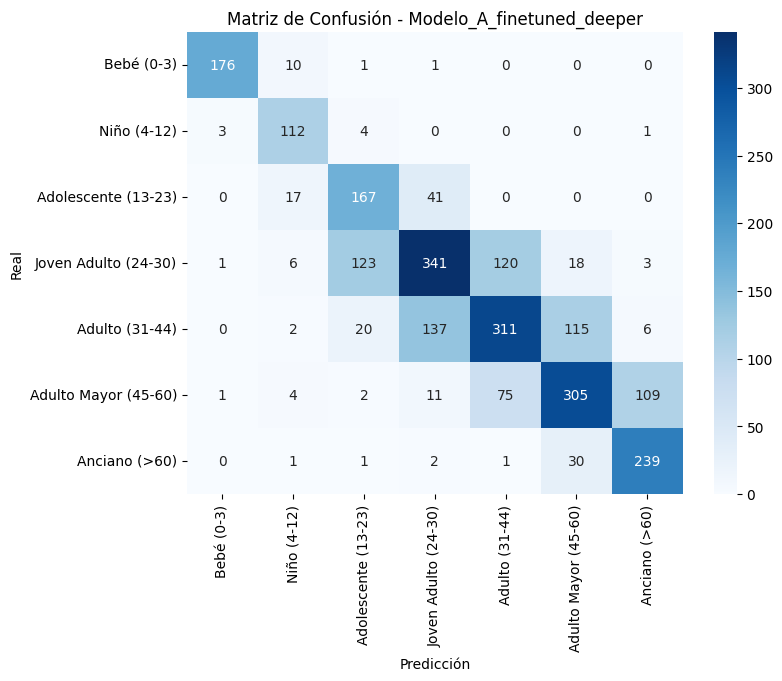

📋 Reporte de clasificación:
                      precision    recall  f1-score   support

          Bebé (0-3)       0.97      0.94      0.95       188
         Niño (4-12)       0.74      0.93      0.82       120
 Adolescente (13-23)       0.53      0.74      0.62       225
Joven Adulto (24-30)       0.64      0.56      0.60       612
      Adulto (31-44)       0.61      0.53      0.57       591
Adulto Mayor (45-60)       0.65      0.60      0.63       507
       Anciano (>60)       0.67      0.87      0.76       274

            accuracy                           0.66      2517
           macro avg       0.69      0.74      0.71      2517
        weighted avg       0.66      0.66      0.65      2517



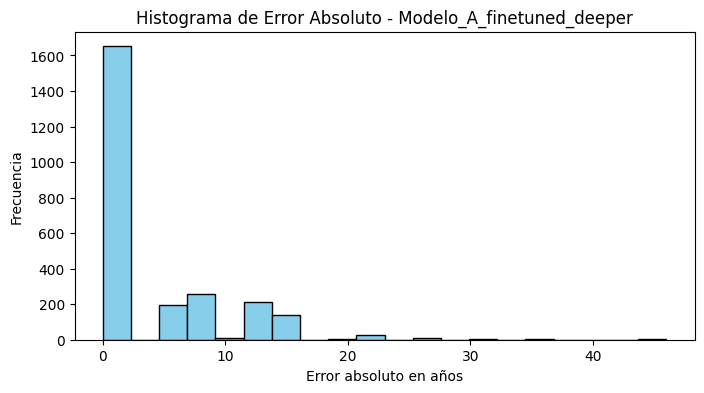

/tmp/ipython-input-22-2854724877.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


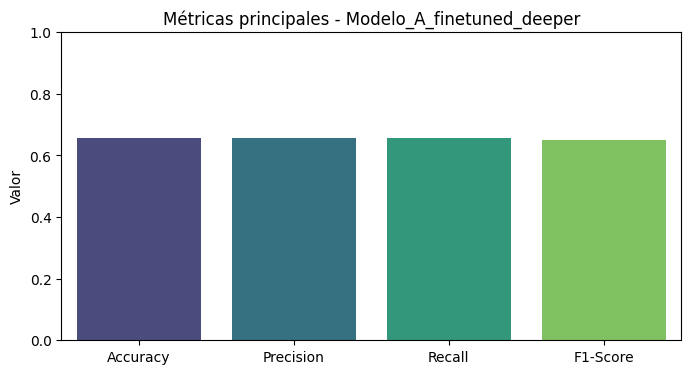

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar matriz de confusión con seaborn
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.figure(figsize=(8,6))
    # heatmap con anotaciones, formato entero y paleta azul
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

# Función para graficar un gráfico de barras para las métricas
def plot_metric_bar(metrics, title):
    plt.figure(figsize=(8,4))
    names = list(metrics.keys())
    values = list(metrics.values())
    sns.barplot(x=names, y=values, palette="viridis")
    plt.ylim(0,1)  # Valores de métricas entre 0 y 1
    plt.title(title)
    plt.ylabel('Valor')
    plt.show()

# Lista con los nombres de modelos a evaluar
model_names = ["Modelo_A_finetuned_deeper"]

# Función para convertir categoría etaria (0 a 7) a edad promedio aproximada en años
def rango_to_edad_promedio(cat):
    # Cada índice corresponde a la edad promedio representativa del rango
    return [1.5, 6.5, 11.5, 16.5, 25, 37.5, 52.5, 70][cat]

# Iteramos sobre los modelos a evaluar
for name in model_names:
    model_path = f"{name}.pt"
    if os.path.exists(model_path):
        print(f"\n📊 Evaluando {name}")

        # Cargar modelo guardado y poner en modo evaluación
        model = torch.load(model_path, map_location=device, weights_only=False)
        model.eval()

        # Cargador para el dataset de validación con batch_size=32
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        errores = []    # Lista para almacenar errores absolutos en años
        correct = 0     # Contador de predicciones correctas
        total = 0       # Total de muestras evaluadas
        all_labels = [] # Etiquetas reales acumuladas
        all_preds = []  # Predicciones acumuladas

        # Evaluación sin cálculo de gradientes (más rápido y menos memoria)
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)               # Predicciones del modelo (logits)
                _, predicted = torch.max(outputs, 1) # Clase con máxima probabilidad

                # Convertir categorías a edades promedio para cálculo de error en años
                edad_real = [rango_to_edad_promedio(l.item()) for l in labels]
                edad_pred = [rango_to_edad_promedio(p.item()) for p in predicted]

                # Agregar los errores absolutos (valor absoluto diferencia entre edades)
                errores += list(np.abs(np.array(edad_real) - np.array(edad_pred)))

                # Guardar etiquetas y predicciones para métricas
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                # Contar cuántas predicciones fueron correctas
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        errores = np.array(errores)  # Convertir a numpy para cálculos estadísticos
        accuracy = 100 * correct / total    # Porcentaje de aciertos
        mae = errores.mean()                 # Error absoluto medio en años
        std = errores.std()                  # Desvío estándar del error absoluto

        # Métricas clásicas de clasificación ponderadas por soporte
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Mostrar métricas por consola
        print(f"✅ Accuracy: {accuracy:.2f}%")
        print(f"📉 MAE: {mae:.2f} años")
        print(f"📊 Desvío estándar del error: {std:.2f}")
        print(f"🎯 Precision (weighted): {precision:.4f}")
        print(f"🎯 Recall (weighted): {recall:.4f}")
        print(f"🎯 F1-Score (weighted): {f1:.4f}")

        # Calcular matriz de confusión y mostrarla gráficamente
        cm = confusion_matrix(all_labels, all_preds)
        plot_confusion_matrix(cm, label_names, title=f'Matriz de Confusión - {name}')

        # Imprimir reporte de clasificación detallado con precisión, recall y F1 por clase
        print("📋 Reporte de clasificación:")
        print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

        # Mostrar histograma de errores absolutos (en años)
        plt.figure(figsize=(8,4))
        plt.hist(errores, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histograma de Error Absoluto - {name}')
        plt.xlabel('Error absoluto en años')
        plt.ylabel('Frecuencia')
        plt.show()

        # Graficar barras con las métricas principales para visualización rápida
        metrics = {
            'Accuracy': accuracy/100,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        plot_metric_bar(metrics, title=f'Métricas principales - {name}')

    else:
        print(f"⚠️ Modelo {name} no encontrado.")


# 10. Probar modelo

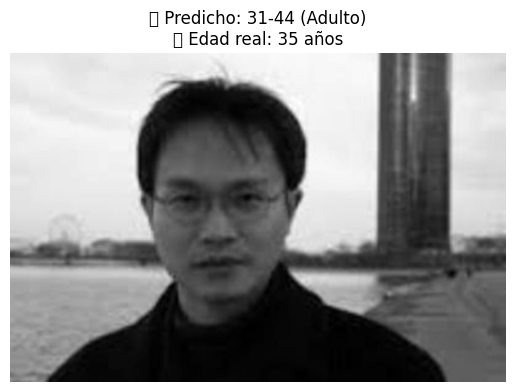

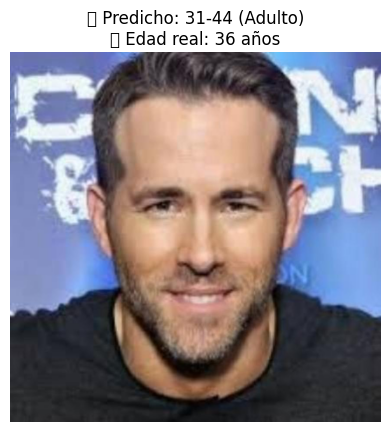

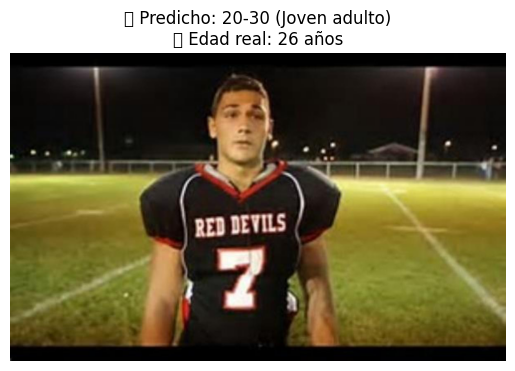

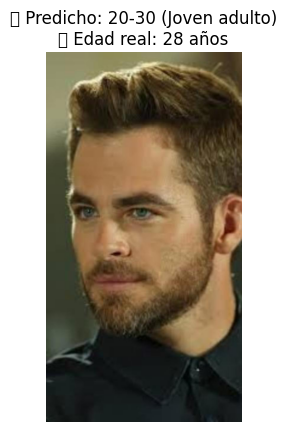

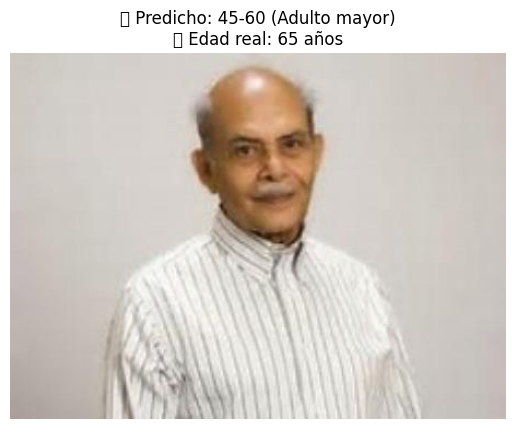

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import os

# Seleccionar dispositivo para cómputo: GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo guardado previamente (modelo fine-tuneado)
model_path = "Modelo_D_finetuned68.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)  # Mover modelo al dispositivo seleccionado
model.eval()      # Poner modelo en modo evaluación (desactiva dropout, batchnorm en modo entrenamiento, etc.)

# Lista de etiquetas de rangos etarios correspondientes a las clases del modelo
age_ranges = [
    "0-3 (Bebé)",
    "4-9 (Niño)",
    "10-13 (Preadolescente)",
    "14-19 (Adolescente)",
    "20-30 (Joven adulto)",
    "31-44 (Adulto)",
    "45-60 (Adulto mayor)",
    "61+ (Anciano)"
]

# Seleccionar 5 imágenes al azar del conjunto de validación para testeo visual
samples = random.sample(val_imgs, 5)

# Iterar sobre las muestras seleccionadas
for img_name, true_class in samples:
    img_path = os.path.join(dataset_path, img_name)          # Ruta completa de la imagen
    image_pil = Image.open(img_path).convert("RGB")          # Abrir imagen y convertir a RGB para procesamiento

    # Obtener la edad real a partir del nombre del archivo (primer elemento antes del guion bajo)
    real_age = int(img_name.split("_")[0])

    # Aplicar transformaciones de validación para preparar la imagen para el modelo
    image_tensor = transform_val(image_pil).unsqueeze(0).to(device)
    # .unsqueeze(0) agrega dimensión batch para que la imagen quede con shape (1, C, H, W)

    with torch.no_grad():   # Desactivar cálculo de gradientes (modo inferencia)
        output = model(image_tensor)               # Obtener logits de salida del modelo
        predicted_class = output.argmax(dim=1).item()  # Tomar índice de clase con mayor probabilidad

    predicted_range = age_ranges[predicted_class]  # Traducir índice de clase a rango etario legible

    # Mostrar imagen con título que indica predicción y edad real
    plt.imshow(image_pil)
    plt.axis("off")  # Ocultar ejes para mejor presentación
    plt.title(f"🧠 Predicho: {predicted_range}\n✅ Edad real: {real_age} años")
    plt.show()


# 11. Probar con imagenes nuestras

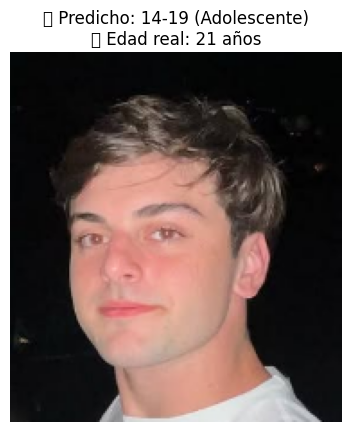

In [ ]:
# 📸 Imagen tuya (ya colocada en el dataset con nombre tipo edad_genero_raza_fecha.jpg)
custom_img_name = "21_Juanfran.png"  # Cambiá este nombre por el de tu imagen
custom_img_path = custom_img_name

# 🖼️ Abrir y procesar imagen
image_pil = Image.open(custom_img_path).convert("RGB")
real_age = int(custom_img_name.split("_")[0])  # Extraer edad desde el nombre

image_tensor = transform_val(image_pil).unsqueeze(0).to(device)

# 🔍 Inferencia
with torch.no_grad():
    output = model(image_tensor)
    predicted_class = output.argmax(dim=1).item()

predicted_range = age_ranges[predicted_class]

# 📊 Mostrar resultados
plt.imshow(image_pil)
plt.axis("off")
plt.title(f"🧠 Predicho: {predicted_range}\n✅ Edad real: {real_age} años")
plt.show()
